# Customer Segmentation using K-Means Clustering.

## Step 1: Load and Inspect the Data

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = r"C:\Users\microstar\Desktop\indolik\extracted_files\online_retail_II.xlsx"

# Load both sheets and merge them
sheets = ["Year 2009-2010", "Year 2010-2011"]
data = pd.read_excel(file_path, sheet_name=None)
df = pd.concat(data.values(), ignore_index=True)

# Display first few rows
df.head()

# Summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


## Checking Sheets and Columns

In [14]:
# Check sheet names
print("Sheets in the file:", data.keys())

# Display column names
print("Columns in dataset:", df.columns.tolist())

# Count the number of unique values in each column
df.nunique()

Sheets in the file: dict_keys(['Year 2009-2010', 'Year 2010-2011'])
Columns in dataset: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']


Invoice        53628
StockCode       5305
Description     5698
Quantity        1057
InvoiceDate    47635
Price           2807
Customer ID     5942
Country           43
dtype: int64

## Step 2: Data Cleaning

In [16]:
# Check for missing values
print(df.isnull().sum())

# Remove rows with missing Customer ID
df = df.dropna(subset=["Customer ID"])

# Remove negative or zero values in Quantity and Price
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


## Step 3: RFM Analysis for Both Years

 Recency, Frequency, and Monetary (RFM) Analysis is used to understand customer behavior.

In [18]:
# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Define the latest date in the dataset
latest_date = df["InvoiceDate"].max()

# Compute RFM metrics
rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (latest_date - x.max()).days,  # Recency
    "Invoice": "nunique",  # Frequency
    "Price": "sum"  # Monetary
})

# Rename columns
rfm.rename(columns={"InvoiceDate": "Recency", "Invoice": "Frequency", "Price": "Monetary"}, inplace=True)

## Step 4: Data Normalization

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

## Step 5: Determine Optimal Number of Clusters (Elbow Method)

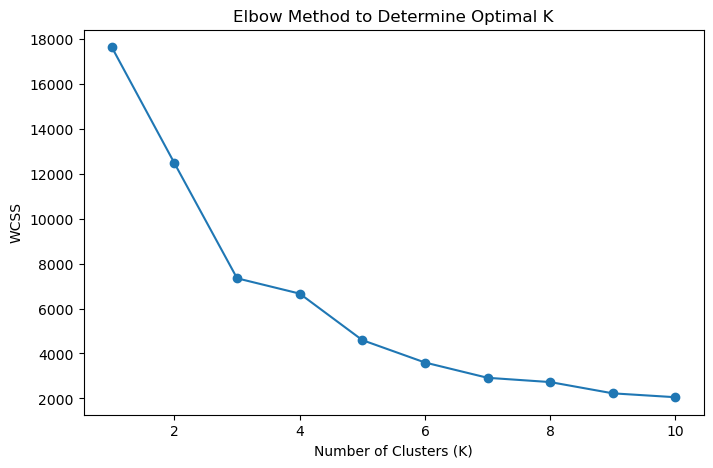

In [22]:
from sklearn.cluster import KMeans

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method to Determine Optimal K")
plt.show()

## Step 6: Apply K-Means Clustering

In [30]:
# Apply K-Means with optimal K (e.g., 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

# View cluster statistics
rfm.groupby("Cluster").mean()

,Recency,Frequency,Monetary
Cluster,,,
0,325.139594,2.679569,179.298916
1,47.279639,8.481503,565.643482
2,35.363636,195.363636,22141.679091
3,585.583916,1.724942,134.096459


## Step 7: Visualizing Customer Segments

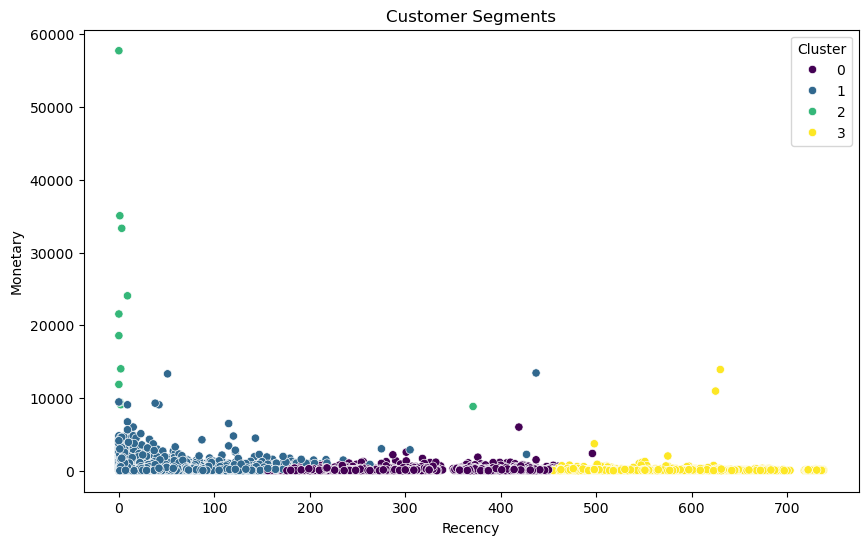

In [33]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=rfm["Recency"], y=rfm["Monetary"], hue=rfm["Cluster"], palette="viridis")
plt.xlabel("Recency")
plt.ylabel("Monetary")
plt.title("Customer Segments")
plt.show()

## Customer Behavior Evolution: 2009-2011

We compare customer segmentation results for each year separately:

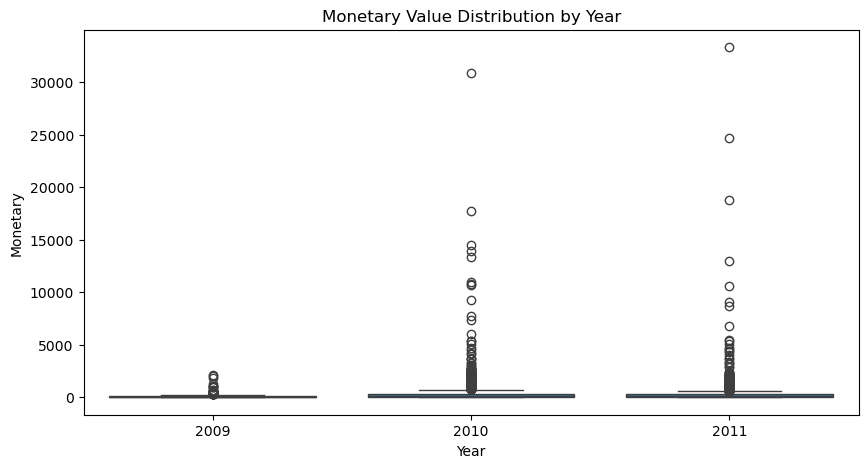

In [42]:
# Segment customers by year
df["Year"] = df["InvoiceDate"].dt.year
rfm_yearly = df.groupby(["Customer ID", "Year"]).agg({
    "InvoiceDate": lambda x: (latest_date - x.max()).days,
    "Invoice": "nunique",
    "Price": "sum"
}).reset_index()

rfm_yearly.rename(columns={"InvoiceDate": "Recency", "Invoice": "Frequency", "Price": "Monetary"}, inplace=True)

# Plot monetary value per year
plt.figure(figsize=(10,5))
sns.boxplot(x="Year", y="Monetary", data=rfm_yearly)
plt.title("Monetary Value Distribution by Year")
plt.show()

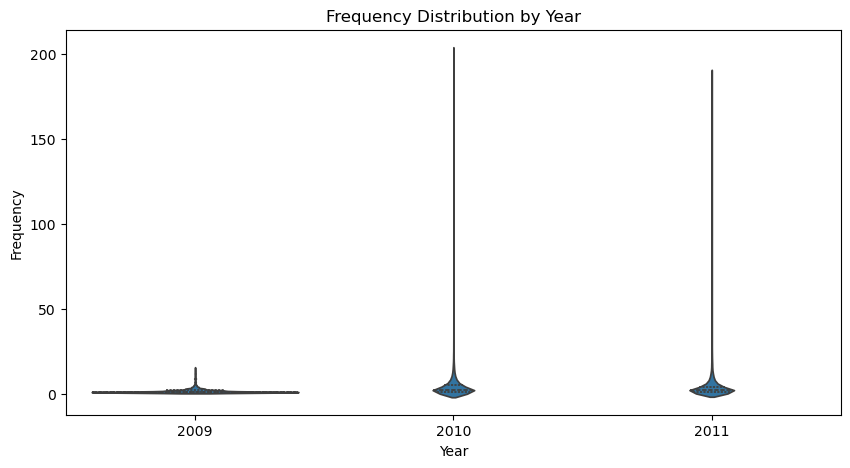

In [47]:
# Segment customers by year
df["Year"] = df["InvoiceDate"].dt.year
rfm_yearly = df.groupby(["Customer ID", "Year"]).agg({
    "InvoiceDate": lambda x: (latest_date - x.max()).days,
    "Invoice": "nunique",
    "Price": "sum"
}).reset_index()

rfm_yearly.rename(columns={"InvoiceDate": "Recency", "Invoice": "Frequency", "Price": "Monetary"}, inplace=True)

# Plot frequency distribution by year
plt.figure(figsize=(10,5))
sns.violinplot(x="Year", y="Frequency", data=rfm_yearly, inner="quartile")
plt.title("Frequency Distribution by Year")
plt.show()